In [1]:
# Standard library imports
import warnings
import time
from pprint import pprint

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import cupy as cp
import tqdm
from scipy.interpolate import interp1d
import torchaudio
import torchaudio.functional as AF
import torchaudio.transforms as AT

# Jupyter notebook specific
%matplotlib inline

# Suppress warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# Local imports - core functionality
from coredldev.dataset import CoReDataset
from coredldev.utilites.pipeline import pipeline

# Local imports - finders and sources
from coredldev.finders.distance_scaling.h5 import h5Finder
from coredldev.sources.distance_scaling.h5 import h5Source

# Local imports - preprocessing steps
from coredldev.preprocessing.raw_postmerger.detector_angle_mixing import DetectorAngleMixing
from coredldev.preprocessing.raw_postmerger.fast_detector_angle_mixing import detector_angle_mixing as fastdam
from coredldev.preprocessing.raw_postmerger.distance_scale import distance_scale
from coredldev.preprocessing.raw_postmerger.time_shift import time_shift
from coredldev.preprocessing.to_tensor import to_tensor_clean
from coredldev.preprocessing.ligo_noise.inject_noise import NoiseInjection1D as noise_injection_1d
from coredldev.preprocessing.wavelet_transforms.morlet import MorletWaveletTransform
from coredldev.preprocessing.whiten import TimeSeriesWhitener
from pycbc.types import TimeSeries

# Import PyCBC libraries
import pycbc.noise
import pycbc.psd
import pycbc.filter

import scipy
from scipy.signal import welch

from copy import deepcopy as dp

# Load frequency values for plotting
freqs = np.genfromtxt("freqs.npy")


/mnt/c/Users/aashr/Desktop/research/Core_DB_Pytorch_Dataloaders_System/.venv/lib/python3.12/site-packages/behavelet/morlet.py:290: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
  if n_jobs is not 1 and not gpu:
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/mnt/c/Users/aashr/Desktop/research/Core_DB_Pytorch_Dataloaders_System/.venv/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/mnt/c/Users/aashr/Desktop/research/Core_DB_Pytorch_Dataloaders_System/.venv/lib/python3.12/site-packages/pycbc/waveform/nltides.py:8: SyntaxWarning: invalid escape sequence '\p'
  """Calculate the change to the Fourier phase change due
/mnt/c/Users/aashr/Desktop/research/Core_DB_Pytorch_Dataloaders_System/.venv/lib/pyt

In [2]:
# datapoints, eosmap, remaining = h5Finder().get_datapoints()
datapoints, eosmap, remaining = h5Finder(shiftpercents=[0],angles=[(0,0,0)],distances = [20]).get_datapoints()
source = h5Source(eos_to_index_map=eosmap)
dataset = CoReDataset(source, datapoints,lambda x: x)
transformed_dataset = CoReDataset(source, datapoints,pipeline([DetectorAngleMixing(),distance_scale(),time_shift(),noise_injection_1d(),TimeSeriesWhitener(4,2),to_tensor_clean()]))
morl = MorletWaveletTransform(freqs=np.loadtxt("freqs.npy"))
fdam = DetectorAngleMixing()
ds = distance_scale()
ts = time_shift()
ni = noise_injection_1d(psd_file = "CE40-asd.txt")
ttc = to_tensor_clean()
morl = MorletWaveletTransform(freqs=np.loadtxt("freqs.npy"))
# pycbcwhitener = whiten_signal(30)
tswhitener = TimeSeriesWhitener(4,2)
data = dataset[400]
print(f"0 {data["hplus"].shape = }")
data1 = fdam(dp(data))
print(f"1 {data1["signal"].shape = }")
data2 = ds(dp(data1))
print(f"2 {data2["signal"].shape = }")
data3 = ts(dp(data2))
print(f"3 {data3["signal"].shape = }")
data4 = ni(dp(data3))
print(f"4 {data4["signal"].shape = }")
# data5 = tswhitener(dp(data4))
# print(f"5 {data5["signal"].shape = }")
print()
prenoise_signal = data3["signal"]
signal = data4["signal"] 
sam_p = data4["params"]["sam_p"]

1
1 1 1
0 data["hplus"].shape = (4461,)
1 data1["signal"].shape = (4461,)
2 data2["signal"].shape = (4461,)
3 data3["signal"].shape = (20000,)
4 data4["signal"].shape = (20000,)



In [3]:
def analyze_signal_frequencies(signal, sampling_period,name,plot = False):
    """
    Perform FFT analysis on a signal and extract frequency information
    
    Parameters:
    -----------
    signal : array-like
        Time domain signal to analyze
    sampling_period : float
        The sampling period in seconds
        
    Returns:
    --------
    tuple
        (min_nonzero_freq, max_freq, freq_bins, fft_magnitude)
        - min_nonzero_freq: minimum nonzero frequency with significant magnitude
        - max_freq: maximum frequency with significant magnitude
        - freq_bins: array of frequency bins
        - fft_magnitude: array of magnitude values
    """
    # Calculate sampling frequency
    sampling_frequency = 1.0 / sampling_period
    
    # Calculate FFT
    fft_result = np.fft.rfft(signal)
    fft_magnitude = np.abs(fft_result)
    
    # Calculate frequency bins
    n_samples = len(signal)
    freq_bins = np.fft.rfftfreq(n_samples, d=sampling_period)
    
    # Find significant peaks (frequencies)
    # Using a simple threshold approach - you might want to adjust this
    threshold = 0.1 * np.max(fft_magnitude)
    peak_indices = np.where(fft_magnitude > threshold)[0]
    peak_freqs = freq_bins[peak_indices]
    peak_magnitudes = fft_magnitude[peak_indices]
    
    # Sort peaks by magnitude
    sort_indices = np.argsort(peak_magnitudes)[::-1]
    sorted_freqs = peak_freqs[sort_indices]
    sorted_magnitudes = peak_magnitudes[sort_indices]
    
    # Find the maximum frequency (using a small threshold to avoid noise)
    noise_threshold = 1e-10 * np.max(fft_magnitude)
    nonzero_indices = np.where(fft_magnitude > noise_threshold)[0]
    
    # Find the maximum frequency
    if len(nonzero_indices) > 0:
        max_freq_index = nonzero_indices[-1]
        max_freq = freq_bins[max_freq_index]
    else:
        max_freq = 0.0
    
    # Find the minimum non-zero frequency (excluding DC component at index 0)
    nonzero_indices = nonzero_indices[nonzero_indices > 0] if len(nonzero_indices) > 0 else []
    if len(nonzero_indices) > 0:
        min_nonzero_freq_index = nonzero_indices[0]
        min_nonzero_freq = freq_bins[min_nonzero_freq_index]
    else:
        min_nonzero_freq = 0.0
    
    # Plot the results
    if plot:
        plt.figure(figsize=(8, 6))
        
        # Plot 1: Full spectrum
        plt.subplot(211)
        plt.loglog(freq_bins, fft_magnitude)
        plt.grid(True, alpha=0.3)
        plt.title(f'Frequency Spectrum: {name}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        
        # Add vertical lines for min and max frequencies
        plt.axvline(x=min_nonzero_freq, color='g', linestyle='--', 
                    label=f'Min non-zero freq: {min_nonzero_freq:.2f} Hz')
        plt.axvline(x=max_freq, color='r', linestyle='--',
                    label=f'Max freq: {max_freq:.2f} Hz')
        plt.legend()
        
        # Plot 2: Log scale view for better visibility of smaller components
        plt.subplot(212)
        plt.loglog(freq_bins, fft_magnitude)
        plt.grid(True, alpha=0.3)
        plt.title('Frequency Spectrum (log scale)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (log scale)')
        
        # Add vertical lines on log plot too
        plt.axvline(x=min_nonzero_freq, color='g', linestyle='--', 
                    label=f'Min non-zero freq: {min_nonzero_freq:.2f} Hz')
        plt.axvline(x=max_freq, color='r', linestyle='--',
                    label=f'Max freq: {max_freq:.2f} Hz')
        plt.legend()
        
        plt.tight_layout()
    
    # Print the min and max frequencies
    print(f"Signal name: {name}")
    print(f"Minimum non-zero frequency: {min_nonzero_freq:.2f} Hz")
    print(f"Maximum frequency: {max_freq:.2f} Hz")
    print()
    
    # Return min and max frequencies along with the frequency data
    return min_nonzero_freq, max_freq, freq_bins, fft_magnitude

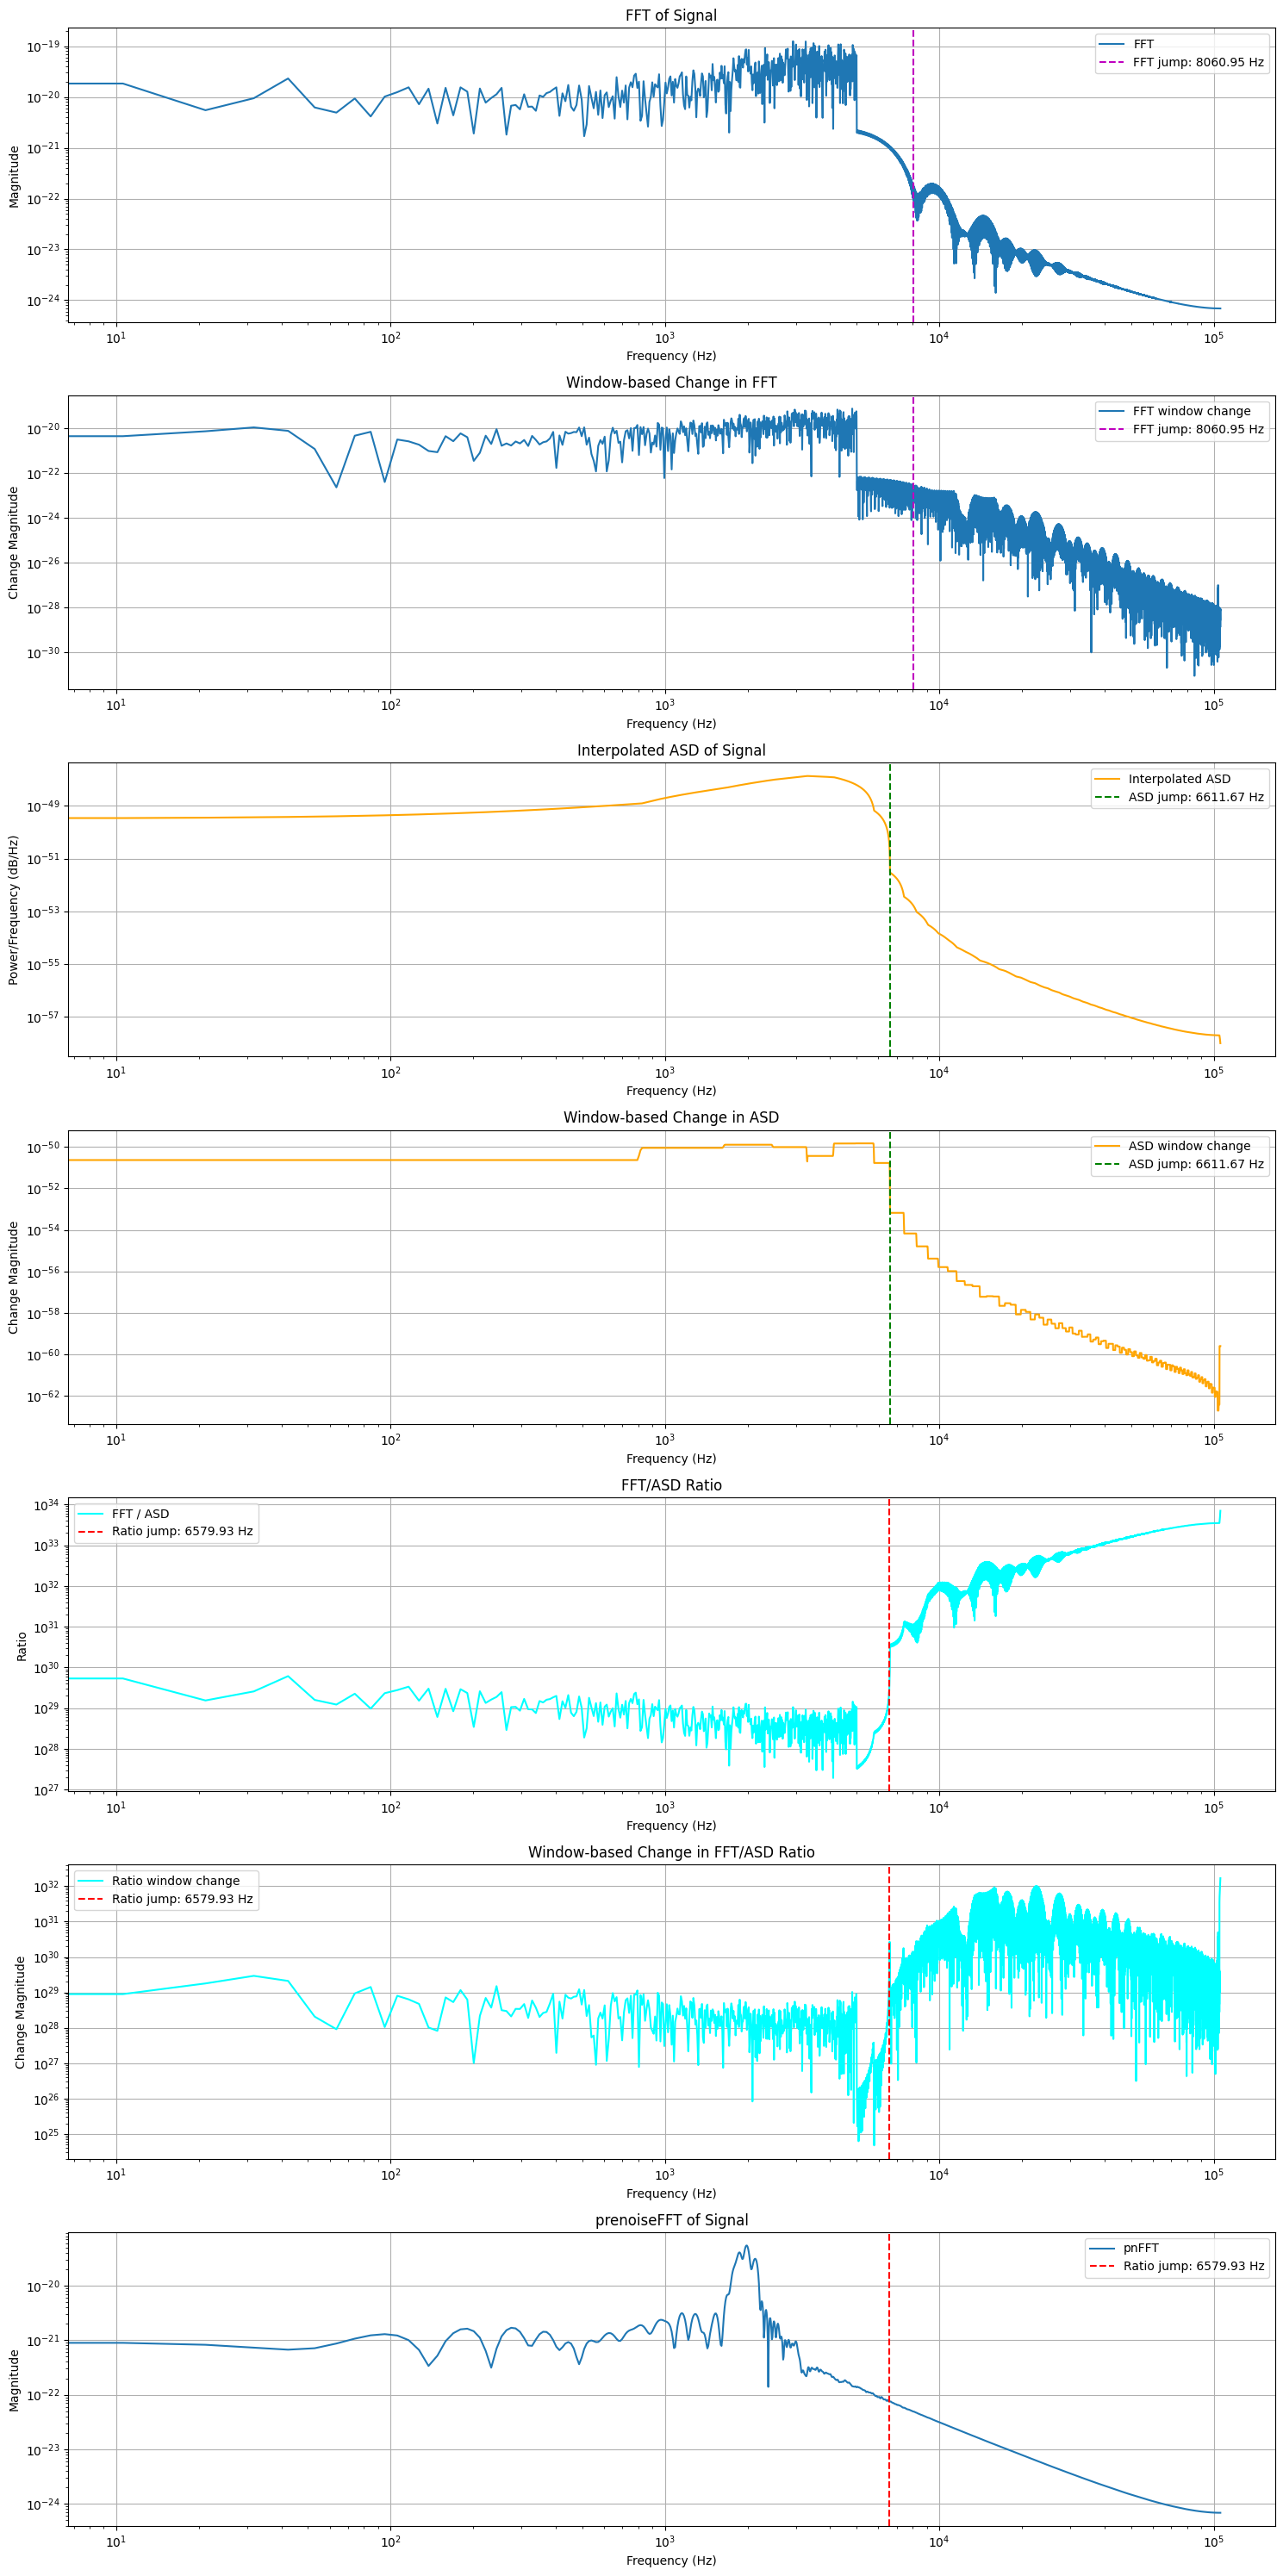

In [4]:

window_size = 4
fft = np.fft.rfft(signal)
fft_freqs = np.fft.rfftfreq(len(signal), d=sam_p)
asd = welch(signal, fs=1/sam_p, nperseg=256)
asd_freqs = asd[0]
asd_values = asd[1]

# Find sharp jumps using a window-based approach
def find_sharp_jump(values, freqs, window_size=window_size, start_percent=0.05):
    """Find sharp jumps in spectrum using window comparison instead of derivatives"""
    # Skip the first few percent to avoid DC component
    start_idx = int(start_percent * len(values))
    
    # Calculate changes over windows
    changes = []
    for i in range(start_idx, len(values) - window_size):
        before_avg = np.mean(values[i-window_size:i]) if i >= window_size else values[i]
        after_avg = np.mean(values[i:i+window_size])
        # Calculate relative change - use absolute value
        if before_avg > 0:  # Avoid division by zero
            change = np.abs((after_avg - before_avg) / before_avg)
        else:
            change = 0
        changes.append(change)
    changes = np.array(changes)
    changes = np.log10(changes + 1e-40)  # Avoid log(0)
    # Find the index of maximum change
    if len(changes) > 0:
        max_change_idx = np.argmax(changes)
        jump_idx = start_idx + max_change_idx
        return jump_idx, freqs[jump_idx]
    else:
        return start_idx, freqs[start_idx]

# Find jumps in FFT and ASD
fft_magnitude = np.abs(fft)
fft_jump_idx, fft_jump_freq = find_sharp_jump(fft_magnitude, fft_freqs, window_size=10)

# For ASD, interpolate first to get better resolution
interpolator = interp1d(asd_freqs, asd_values, kind='linear', bounds_error=False, fill_value=0)
interpolated_asd_values = interpolator(fft_freqs)
asd_jump_idx, asd_jump_freq = find_sharp_jump(interpolated_asd_values, fft_freqs, window_size=10)

# Calculate and find jump in FFT/ASD ratio
ratio = fft_magnitude / interpolated_asd_values
ratio_jump_idx, ratio_jump_freq = find_sharp_jump(ratio, fft_freqs, window_size=10)

# Calculate window-based derivatives for plotting
def window_derivative(values, window_size=window_size):
    derivatives = np.zeros(len(values) - window_size)
    for i in range(len(derivatives)):
        before_avg = np.mean(values[i:i+window_size//2])
        after_avg = np.mean(values[i+window_size//2:i+window_size])
        derivatives[i] = after_avg - before_avg
    return derivatives

# Calculate window derivatives
fft_window_diff = window_derivative(fft_magnitude)
asd_window_diff = window_derivative(interpolated_asd_values)
ratio_window_diff = window_derivative(ratio)

# Plot with 7 subplots (added one for ratio derivative)
plt.figure(figsize=(15, 30))

# Plot FFT
plt.subplot(711)
plt.loglog(fft_freqs, fft_magnitude, label="FFT")
plt.axvline(x=fft_jump_freq, color='m', linestyle='--', 
            label=f'FFT jump: {fft_jump_freq:.2f} Hz')
plt.title("FFT of Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()

# Plot the window-based derivative of FFT
plt.subplot(712)
plt.loglog(fft_freqs[:-window_size], np.abs(fft_window_diff), label="FFT window change")
plt.axvline(x=fft_jump_freq, color='m', linestyle='--', 
            label=f'FFT jump: {fft_jump_freq:.2f} Hz')
plt.title("Window-based Change in FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Change Magnitude")
plt.grid(True)
plt.legend()

# Plot interpolated ASD
plt.subplot(713)
plt.loglog(fft_freqs, interpolated_asd_values, label="Interpolated ASD", color='orange')
plt.axvline(x=asd_jump_freq, color='g', linestyle='--', 
            label=f'ASD jump: {asd_jump_freq:.2f} Hz')
plt.title("Interpolated ASD of Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.grid(True)
plt.legend()

# Plot the window-based derivative of ASD
plt.subplot(714)
plt.loglog(fft_freqs[:-window_size], np.abs(asd_window_diff), label="ASD window change", color='orange')
plt.axvline(x=asd_jump_freq, color='g', linestyle='--', 
            label=f'ASD jump: {asd_jump_freq:.2f} Hz')
plt.title("Window-based Change in ASD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Change Magnitude")
plt.grid(True)
plt.legend()

# Plot FFT/ASD ratio
plt.subplot(715)
plt.loglog(fft_freqs, ratio, label="FFT / ASD", color='cyan')
plt.axvline(x=ratio_jump_freq, color='r', linestyle='--', 
            label=f'Ratio jump: {ratio_jump_freq:.2f} Hz')
plt.title("FFT/ASD Ratio")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Ratio")
plt.grid(True)
plt.legend()

# Plot the window-based derivative of FFT/ASD ratio
plt.subplot(716)
plt.loglog(fft_freqs[:-window_size], np.abs(ratio_window_diff), label="Ratio window change", color='cyan')
plt.axvline(x=ratio_jump_freq, color='r', linestyle='--', 
            label=f'Ratio jump: {ratio_jump_freq:.2f} Hz')
plt.title("Window-based Change in FFT/ASD Ratio")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Change Magnitude")
plt.grid(True)
plt.legend()

# Plot pre-noise FFT
plt.subplot(717)
pnfft = np.fft.rfft(prenoise_signal)
pnfft_freqs = np.fft.rfftfreq(len(prenoise_signal), d=sam_p)
plt.loglog(pnfft_freqs, np.abs(pnfft), label="pnFFT")
plt.axvline(x=ratio_jump_freq, color='r', linestyle='--', 
            label=f'Ratio jump: {ratio_jump_freq:.2f} Hz')
plt.title("prenoiseFFT of Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

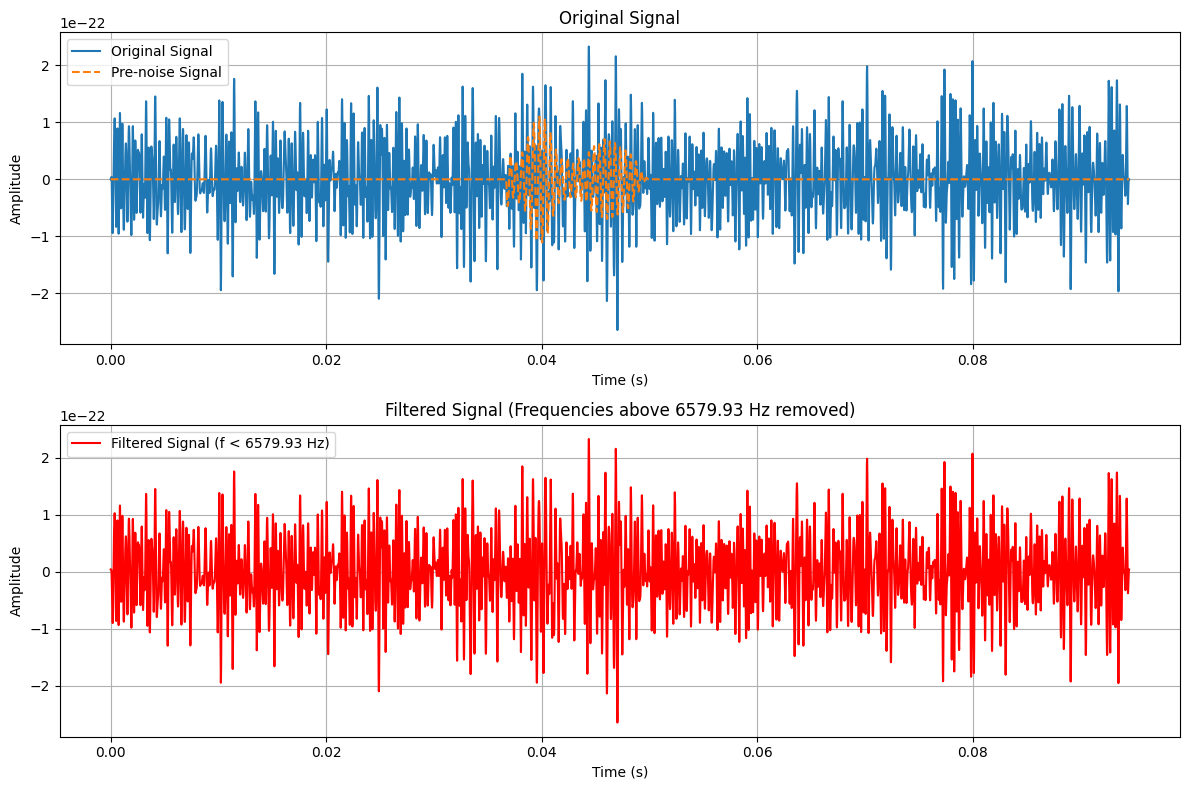

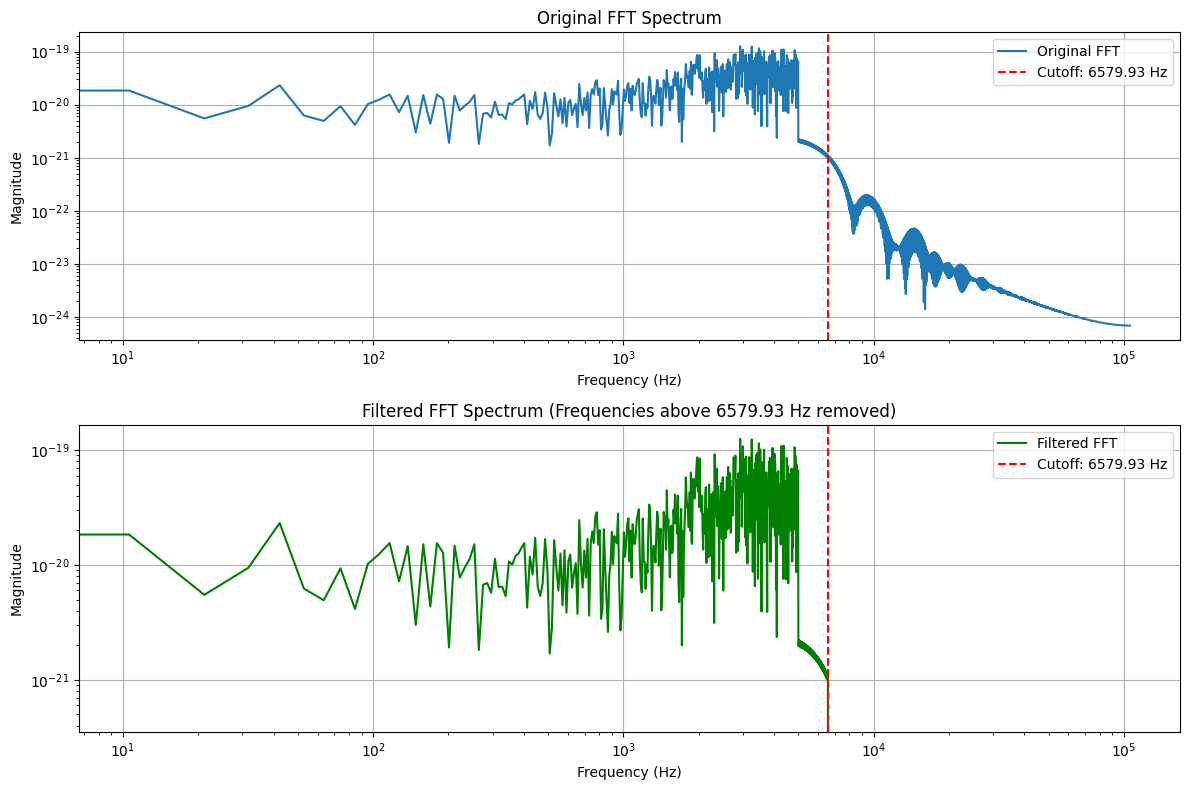

In [6]:
# In a new cell after the existing code:

# Create a copy of the FFT and zero out everything after the sharp jump in the FFT
filtered_fft = np.copy(fft)
filtered_fft[ratio_jump_idx:] = 0

# Perform inverse FFT to get the filtered signal
filtered_signal = np.fft.irfft(filtered_fft)

# Plot original vs filtered signals
plt.figure(figsize=(12, 8))

# Plot original signal
plt.subplot(211)
time_axis = np.arange(len(signal)) * sam_p
plt.plot(time_axis, signal, label="Original Signal")
plt.plot(time_axis, prenoise_signal, label="Pre-noise Signal", linestyle='--')
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

# Plot filtered signal
plt.subplot(212)
time_axis_filtered = np.arange(len(filtered_signal)) * sam_p
plt.plot(time_axis_filtered, filtered_signal, label=f"Filtered Signal (f < {ratio_jump_freq:.2f} Hz)", color="red")
plt.title(f"Filtered Signal (Frequencies above {ratio_jump_freq:.2f} Hz removed)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Compare FFT of original and filtered signals
plt.figure(figsize=(12, 8))

# Plot original FFT
plt.subplot(211)
plt.loglog(fft_freqs, np.abs(fft), label="Original FFT")
plt.axvline(x=ratio_jump_freq, color='r', linestyle='--', 
            label=f'Cutoff: {ratio_jump_freq:.2f} Hz')
plt.title("Original FFT Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()

# Plot filtered FFT
plt.subplot(212)
plt.loglog(fft_freqs, np.abs(filtered_fft), label="Filtered FFT", color='green')
plt.axvline(x=ratio_jump_freq, color='r', linestyle='--', 
            label=f'Cutoff: {ratio_jump_freq:.2f} Hz')
plt.title(f"Filtered FFT Spectrum (Frequencies above {ratio_jump_freq:.2f} Hz removed)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

/mnt/c/Users/aashr/Desktop/research/Core_DB_Pytorch_Dataloaders_System/.venv/lib/python3.12/site-packages/pycbc/inject/inject.py:341: SyntaxWarning: invalid escape sequence '\*'
  """Manages sets of injections: reads injections from hdf files
/mnt/c/Users/aashr/Desktop/research/Core_DB_Pytorch_Dataloaders_System/.venv/lib/python3.12/site-packages/pycbc/inject/inject.py:447: SyntaxWarning: invalid escape sequence '\*'
  """Writes the injection samples to the given hdf file.
/mnt/c/Users/aashr/Desktop/research/Core_DB_Pytorch_Dataloaders_System/.venv/lib/python3.12/site-packages/pycbc/inject/inject.py:1079: SyntaxWarning: invalid escape sequence '\*'
  """Manages sets of injections and injects them into time series.
/mnt/c/Users/aashr/Desktop/research/Core_DB_Pytorch_Dataloaders_System/.venv/lib/python3.12/site-packages/pycbc/inject/inject.py:1115: SyntaxWarning: invalid escape sequence '\*'
  """Writes the injection samples to the given hdf file.


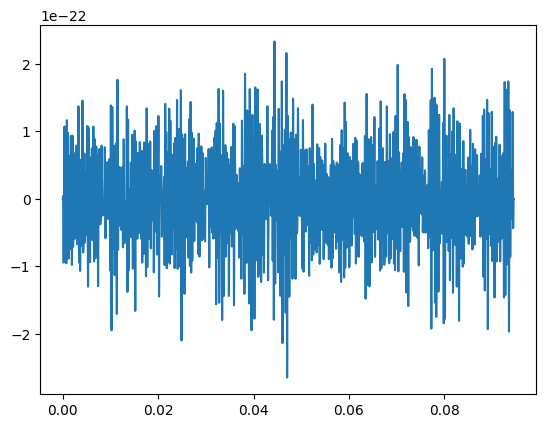

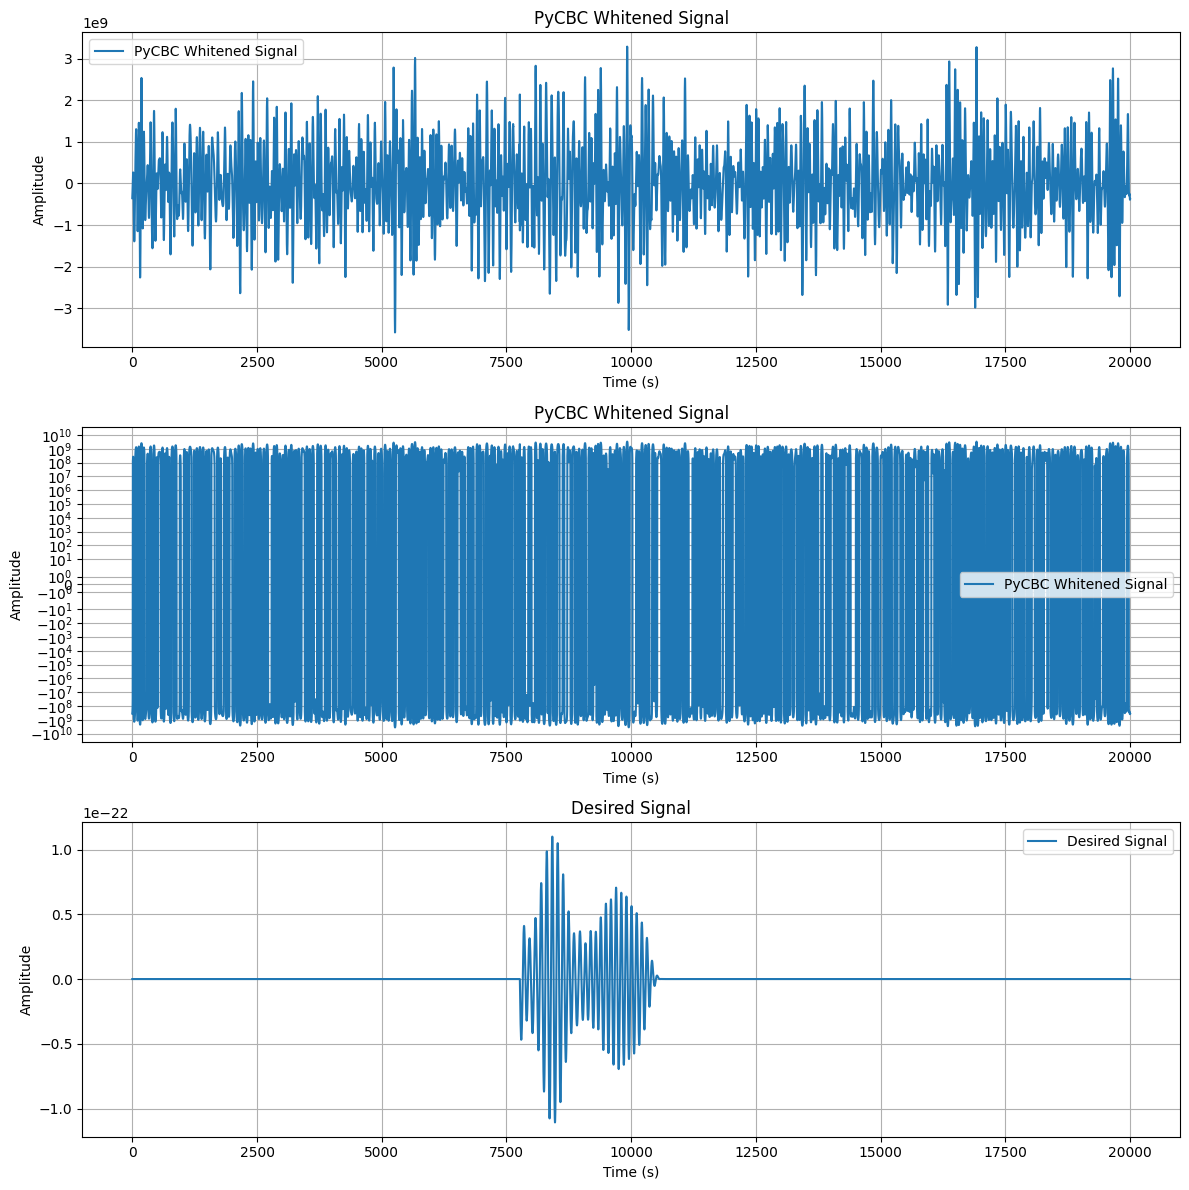

In [7]:
from pycbc.types import TimeSeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
import bilby

# Convert the signal to a PyCBC TimeSeries object
desired_signal = TimeSeries(prenoise_signal, delta_t=sam_p)
pycbc_signal = TimeSeries(signal,delta_t=sam_p)
pycbc_signal.plot()
# whitened_signal_pycbc=pycbc_signal.whiten(40*sam_p,40*sam_p)


# Estimate the Power Spectral Density (PSD) using Welch's method
psd = pycbc_signal.psd((len(pycbc_signal) // 4 ) * sam_p)

# Interpolate and truncate the PSD for whitening
psd = interpolate(psd, pycbc_signal.delta_f)
psd = inverse_spectrum_truncation(psd, int(400), low_frequency_cutoff=20.0)

# Whiten the signal using PyCBC
whitened_signal_pycbc = (pycbc_signal.to_frequencyseries() / psd**0.5).to_timeseries()


# Plot the whitened signals
plt.figure(figsize=(12, 12))

# PyCBC whitened signal
plt.subplot(311)
plt.plot(whitened_signal_pycbc, label="PyCBC Whitened Signal")
plt.title("PyCBC Whitened Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

plt.subplot(312)
plt.plot(whitened_signal_pycbc, label="PyCBC Whitened Signal")
plt.title("PyCBC Whitened Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.gca().set_yscale("symlog")
plt.grid(True)
plt.legend()

# PyCBC whitened signal
plt.subplot(313)
plt.plot(desired_signal, label="Desired Signal")
plt.title("Desired Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
len(signal)*sam_p

0.09452981271760394

In [9]:
import bilby
from bilby.gw.detector.psd import PowerSpectralDensity as psd
minimum_frequency = 7
maximum_frequency = 4096
from gwpy.timeseries import TimeSeries
gwpy_signal = TimeSeries(signal, dt=sam_p)
print(gwpy_signal.duration)
CE40 = bilby.gw.detector.Interferometer(name = "CE40",
                                        power_spectral_density = psd.from_amplitude_spectral_density_file('CE40-asd.txt'),
                                        minimum_frequency = minimum_frequency,
                                        maximum_frequency = maximum_frequency,
                                        length = 40, 
                                        latitude = 46,
                                        longitude = -125,
                                        xarm_azimuth = 260,
                                        yarm_azimuth = 350,
                                        elevation = 0)

0.09452981271760394 s


In [10]:
CE40.set_strain_data_from_gwpy_timeseries(gwpy_signal)

CE40.whitened_time_domain_strain

array([0.00465638, 0.00488816, 0.0050037 , ..., 0.00330546,
       0.0038592 , 0.00431172], shape=(20000,))

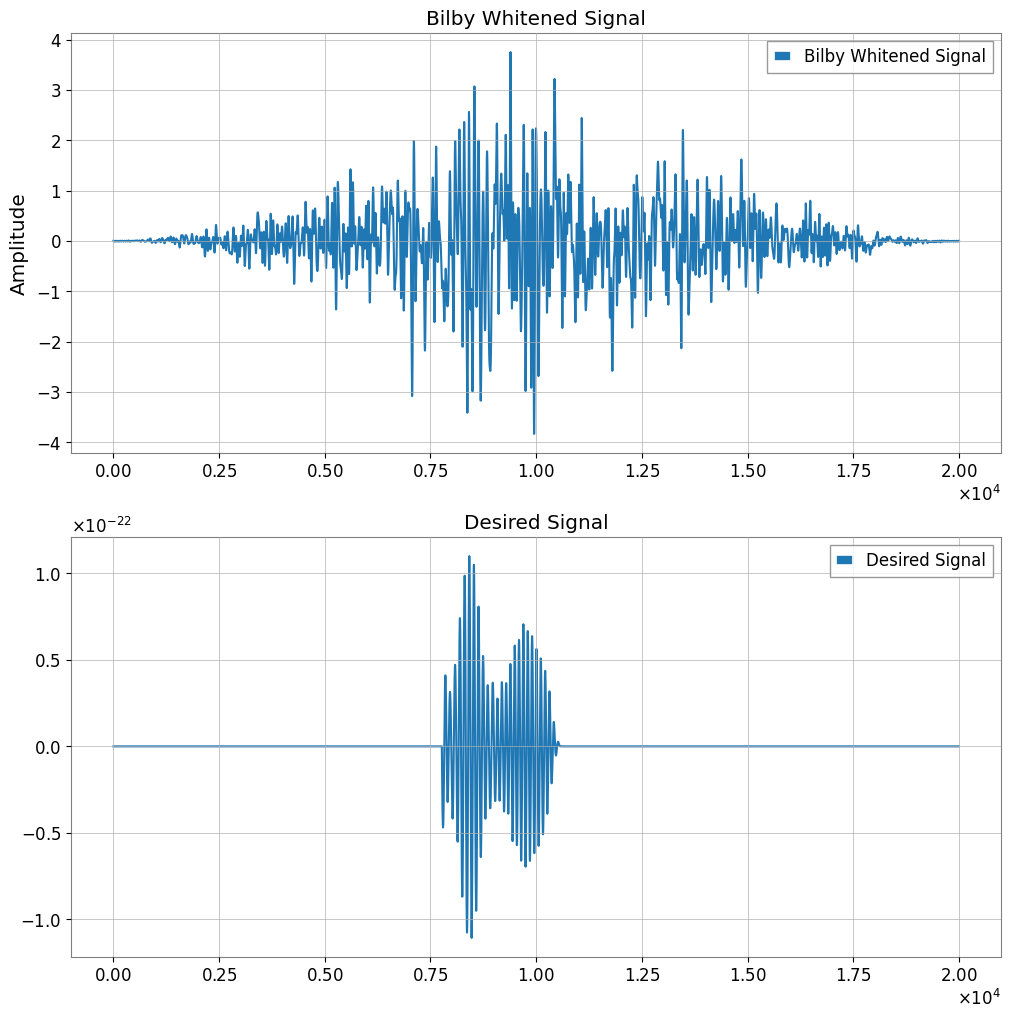

In [11]:
# Whiten the signal using the bilby interferometer


# Plot the whitened signal
plt.figure(figsize=(12, 12))

plt.subplot(211)
plt.plot(CE40.whitened_time_domain_strain, label="Bilby Whitened Signal")
plt.title("Bilby Whitened Signal")
# plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

plt.subplot(212)
plt.plot(desired_signal, label="Desired Signal")
plt.title("Desired Signal")
plt.grid(True)
plt.legend()
plt.show()
# from bilby.core.utils import infft
# data_whitened_strain = (1./(4.*numpy.pi * CE40.duration))*infft(CE40.whitened_frequency_domain_strain,
#                                                                  sampling_frequency=CE40.strain_data.sampling_frequency)
# plt.figure(figsize=(12, 6))
# plt.plot(CE40.whitened_time_domain_strain, label="Bilby Whitened Signal")
# plt.title("Bilby Whitened Signal")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.grid(True)
# plt.legend()
# plt.show()

In [ ]:
20000 * sam_p